# Lesson 3 - Build a Clutter Model

In this lesson you'll create a statistical propagation model to predict loss due to clutter in 3.5 GHz propagation measurements. To create the model you are given two measurement datasets from the Martin Acres neighborhood of Boulder, Colorado. They are located in the `course-materials/data/` directory. 

- **`course-materials/data/MartinAcresLow_3500.MartinAcres.csv`**
- **`course-materials/data/MartinAcresHigh_3500.MartinAcres.csv`**

<img src="./images/measurement_datasets.png" alt="low and high datasets" width="1200"/>

This image shows two datasets made with a 3.5 GHz continuous wave signal transmitted from two different locations: "Low TX", and "High TX." The Low TX antenna is at approximately 1660 meters above sea level. The High TX antenna is at approximately 1800 meters above sea level. On the receiving end, mobile measurements were made in the Martin Acres neighborhood. The terrain of Martin Acres is approximately flat and we can assume that there are no terrain obstructions and only clutter obstructions (buildings and trees) between the RX and TX antennas.

__In this lesson you will:__

**1.** Load the measurement data and plot it on a map.

**2.** Visualize the data: a) Cumulative Distribution and b) Path Distance vs Clutter Loss.

**3.** Determine the _distance within clutter_ for each ray path.

**4.** Fit a regression model to **predict clutter loss based on _distance within clutter_**.

<br/>

### Import the necessary Python libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rasterio
from sklearn.linear_model import LinearRegression

### Load Lesson 2 Lidar clutter statistics for Martin Acres
  * Clutter height mean = 8 meters.
  * Clutter height std. deviation = 4.5 meters.

In [4]:
clutter_height_mean = 8 ## meters
clutter_height_std = 4.5 ## meters

### Bring in Lidar data and static variables

In [5]:
## bring in lidar data (same as lesson 2)
dataset_terrain = rasterio.open("./data/MartinAcres.dtm.tif")
dataset_surface = rasterio.open("./data/MartinAcres.dsm.tif")
band1_terrain = dataset_terrain.read(1)
band1_surface = dataset_surface.read(1)
## set map and lidar bounds (same as lesson 2)
left, bottom, right, top = dataset_terrain.bounds
left_deg, bottom_deg, right_deg, top_deg = (-105.2869255, 39.9747967, -105.2343079, 40.0019534)
## for converting lat and long degrees into meters (same as lesson 2)
meters_per_lat = 111319.49 
meters_per_long = 85263.24 ## only valid at latitudes of 40 degrees

### Load the measurement datasets

The measurement datasets are stored in CSV files and we can load them into [Pandas DataFrames](https://www.datacamp.com/tutorial/pandas-tutorial-dataframe-python). DataFrames are a row/column data structure that allow for efficient manipulation and analysis.

In [15]:
low_file_name = "./data/MartinAcresLow_3500.MartinAcres.csv"
high_file_name = "./data/MartinAcresHigh_3500.MartinAcres.csv"
low_df = pd.read_csv(low_file_name)
high_df = pd.read_csv(high_file_name)

### Look at the first 5 rows of each DataFrame

We can see that each row represents a measured data point, and the columns indicate a variety of available values for each point.

In [16]:
high_df.head(5)

ID      TxLat       TxLon      RxLat       RxLon  h_tx__meter  h_rx__meter  \
0  52  39.991772 -105.274513  39.994728 -105.259446           18            3   
1  53  39.991772 -105.274513  39.994751 -105.259402           18            3   
2  54  39.991772 -105.274513  39.994780 -105.259346           18            3   
3  55  39.991772 -105.274513  39.994813 -105.259286           18            3   
4  56  39.991772 -105.274513  39.994854 -105.259224           18            3   

   f__mhz     d__km  d_3d__km  L_meas__db    L_fs__db  L_excess__db  
0    3500  1.327970  1.336079  115.660022  105.848003      9.812020  
1    3500  1.332266  1.340374  119.475226  105.875882     13.599345  
2    3500  1.337660  1.345767  119.886948  105.910755     13.976192  
3    3500  1.343553  1.351655  117.390078  105.948676     11.441402  
4    3500  1.349809  1.357908  116.609122  105.988770     10.620352

In [17]:
low_df.head(5)

ID      TxLat       TxLon      RxLat       RxLon  h_tx__meter  h_rx__meter  \
0  46  39.994762 -105.262193  39.994728 -105.259444         8.37            3   
1  47  39.994762 -105.262193  39.994751 -105.259401         8.37            3   
2  48  39.994762 -105.262193  39.994778 -105.259350         8.37            3   
3  49  39.994762 -105.262193  39.994808 -105.259294         8.37            3   
4  50  39.994762 -105.262193  39.994843 -105.259241         8.37            3   

   f__mhz     d__km  L_meas__db   L_fs__db  L_excess__db  
0    3500  0.234806  103.632553  90.755528     12.877025  
1    3500  0.238463  106.233469  90.889854     15.343615  
2    3500  0.242833  106.911219  91.047654     15.863565  
3    3500  0.247677  107.819266  91.219261     16.600006  
4    3500  0.252327  107.819266  91.380939     16.438327

### Column definitions 

| Column          | Definition                         |
| --------------- |------------------------------------|
| `ID`            | Identifier                         |
| `TxLat`         | Tx Latitude                        |
| `TxLon`         | Tx Longitude                       |
| `RxLat`         | Rx Latitude                        |
| `RxLon`         | Rx Longitude                       |
| `h_tx__meter`   | Tx Antenna Height                  |
| `h_rx__meter`   | Rx Antenna Height                  |
| `f__mhz`        | Frequency                          |
| `d__km`         | Distance TX to RX                  |
| `d_3d__km`      | 3D Distance TX to RX               |
| `L_meas__db`    | Measured Loss                      |
| `L_fs__db`      | Free-Space Loss                    |
| `L_excess__db`  | Clutter Loss                       |


Here, the "clutter loss" is defined as "measure loss in excess of free space." We will use this definition throughout the rest of the notebook.
`d_3d__km` considers the antenna altitudes when calculating the distance between the TX and RX. Low dataset only has `d__km` because there is very little difference from `d_3d__km`. 

### Add four new columns to the DataFrames

We can add new columns to the existing DataFrames, to store the results of processing which are useful to our analysis. The DataFrame structure also allows for easy row-wise repetition of processing steps, as shown here using `.map()`

Let's convert __`TxLat`, `TxLon`, `RxLat`, and `RxLon` to meters__ for ease of measuring and plotting. We will then add the computed values to the existing DataFrames as new columns.

In [49]:
## functions to convert lat and long to meters
def convert_lat_to_meters(lat):
    lat_dif = top_deg - lat
    vert_dif_m = lat_dif * meters_per_lat
    return vert_dif_m

def convert_long_to_meters(long):
    long_dif = long - left_deg
    horz_dif_m = long_dif * meters_per_long
    return horz_dif_m

## create new columns by mapping the conversion function to lat or long column
for df in [low_df, high_df]:
    df["RxX__meter"] = df["RxLon"].map(convert_long_to_meters)
    df["RxY__meter"] = df["RxLat"].map(convert_lat_to_meters)
    df["TxX__meter"] = df["TxLon"].map(convert_long_to_meters)
    df["TxY__meter"] = df["TxLat"].map(convert_lat_to_meters)

# Look at the new columns `RxX__meter`, `RxY__meter, TxX__meter, TxY__meter
low_df.head(5)

ID      TxLat       TxLon      RxLat       RxLon  h_tx__meter  h_rx__meter  \
0  46  39.994762 -105.262193  39.994728 -105.259444         8.37            3   
1  47  39.994762 -105.262193  39.994751 -105.259401         8.37            3   
2  48  39.994762 -105.262193  39.994778 -105.259350         8.37            3   
3  49  39.994762 -105.262193  39.994808 -105.259294         8.37            3   
4  50  39.994762 -105.262193  39.994843 -105.259241         8.37            3   

   f__mhz     d__km  L_meas__db   L_fs__db  L_excess__db   RxX__meter  \
0    3500  0.234806  103.632553  90.755528     12.877025  2343.127625   
1    3500  0.238463  106.233469  90.889854     15.343615  2346.802470   
2    3500  0.242833  106.911219  91.047654     15.863565  2351.167948   
3    3500  0.247677  107.819266  91.219261     16.600006  2355.951216   
4    3500  0.252327  107.819266  91.380939     16.438327  2360.495747   

   RxY__meter   TxX__meter  TxY__meter  
0  804.282202  2108.730452  800.499566  
1  801.737439  2108.730452  800.499566  
2  798.721794  2108.730452  800.499566  
3  795.407812  2108.730452  800.499566  
4  791.559498  2108.730452  800.499566

### Plot the measurements on a map

In [20]:
## read in Martin Acres map image
##  image from www.openstreetmap.org
martin_acres_map = plt.imread('./images/martin_acres_map.png')

## set the map bounding box (in meters)
BBox = (0,  right-left,      
        top-bottom,  0)

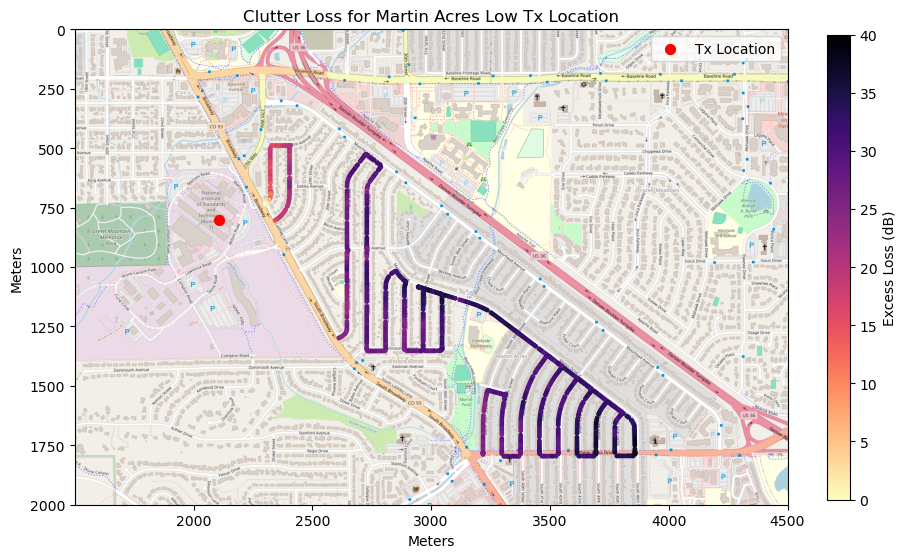

In [31]:
## make the Low plot
fig, ax = plt.subplots(figsize=(10, 10))

## plot the TX location
ex2 = ax.scatter(low_df.iloc[0]["TxX__meter"],low_df.iloc[0]["TxY__meter"], zorder=2, alpha=1.0, c='r', s=50, label="Tx Location")
## plot the Clutter Losses 
ex1 = ax.scatter(low_df["RxX__meter"], low_df["RxY__meter"], zorder=1, c=low_df["L_excess__db"], cmap='magma_r', alpha= 1.0, s=6, vmin=0, vmax=40)

cbar = plt.colorbar(ex1, fraction=0.03, label="Excess Loss (dB)")
ax.set_title('Clutter Loss for Martin Acres Low Tx Location')
ax.set_xlabel("Meters")
ax.set_ylabel("Meters")
ax.set_xlim(BBox[0]+(BBox[1]/3),BBox[1])
ax.set_ylim(BBox[2]-(BBox[2]/3),BBox[3])
ax.imshow(martin_acres_map, zorder=0, extent = BBox, aspect= 'equal')
ax.legend()
plt.show()

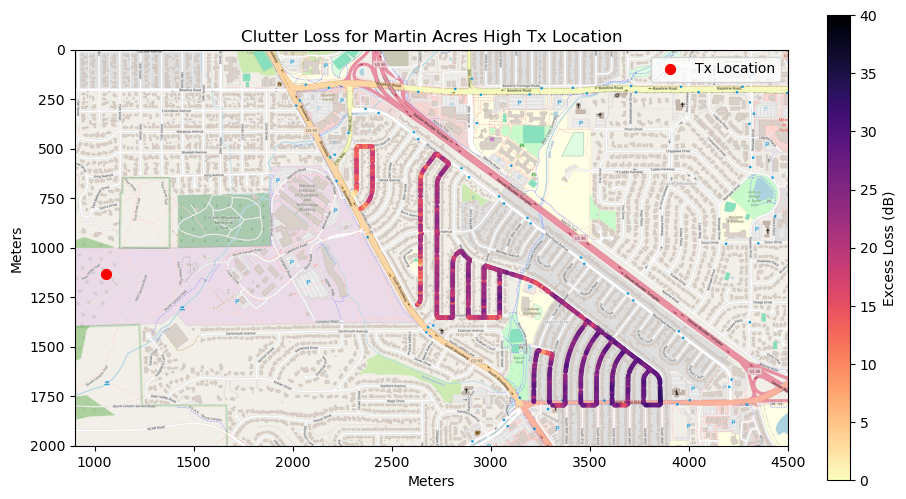

In [75]:
## make the high plot
fig, ax = plt.subplots(figsize=(10, 10))

## plot the Tx location
ex2 = ax.scatter(high_df.iloc[0]["TxX__meter"],high_df.iloc[0]["TxY__meter"], zorder=2, alpha=1.0, c='r', s=50, label="Tx Location")
## plot the Clutter Losses 
ex1 = ax.scatter(high_df["RxX__meter"], high_df["RxY__meter"], zorder=1, c=high_df["L_excess__db"], cmap='magma_r', alpha= 1.0, s=6, vmin=0, vmax=40)

cbar = plt.colorbar(ex1, fraction=0.03, label="Excess Loss (dB)")
ax.set_title('Clutter Loss for Martin Acres High Tx Location')
ax.set_xlabel("Meters")
ax.set_ylabel("Meters")
ax.set_xlim(BBox[0]+(BBox[1]/5),BBox[1])
ax.set_ylim(BBox[2]-(BBox[2]/3),BBox[3])
ax.imshow(martin_acres_map, zorder=0, extent = BBox, aspect= 'equal')
ax.legend()
plt.show()

### Plot the Cumulative Distribution Function (CDF) of the Clutter Loss for High and Low

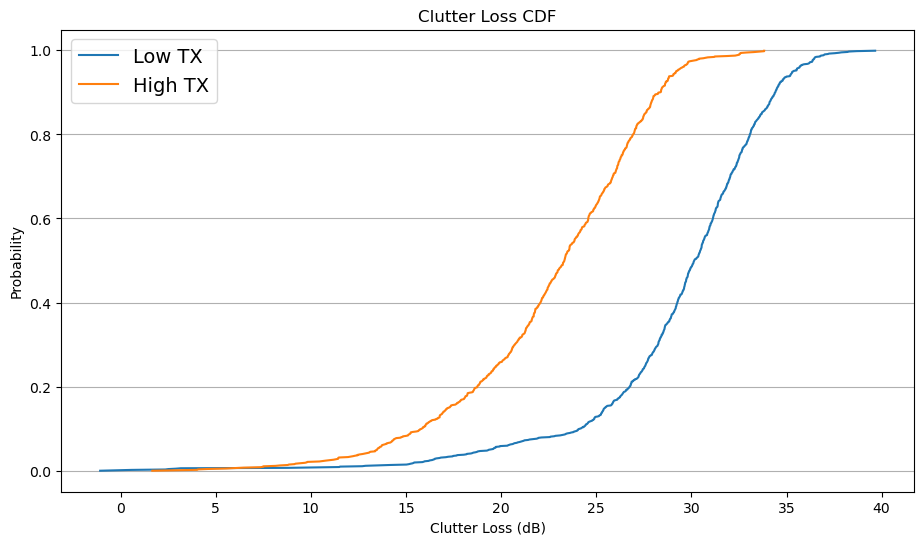

In [48]:
low_N = len(low_df)
low_x = np.sort(low_df["L_excess__db"])
low_y = np.arange(low_N) / float(low_N)

## plot the CDF
fig, ax = plt.subplots(figsize=(11, 6))
ax.plot(low_x, low_y, label='Low TX')

high_N = len(high_df)
high_x = np.sort(high_df["L_excess__db"])
high_y = np.arange(high_N) / float(high_N)
## plot the CDF
ax.plot(high_x, high_y, label='High TX')

ax.set_xlabel('Clutter Loss (dB)')
ax.set_ylabel('Probability')
ax.set_title('Clutter Loss CDF')
ax.grid(True, axis="y", which="both")
ax.legend(fontsize=14)
plt.show()

The clutter loss CDF shows that more clutter loss is observed in the Low Tx measurements, compared to the High Tx measurements. 

### Plot the Path Distance vs Clutter Loss

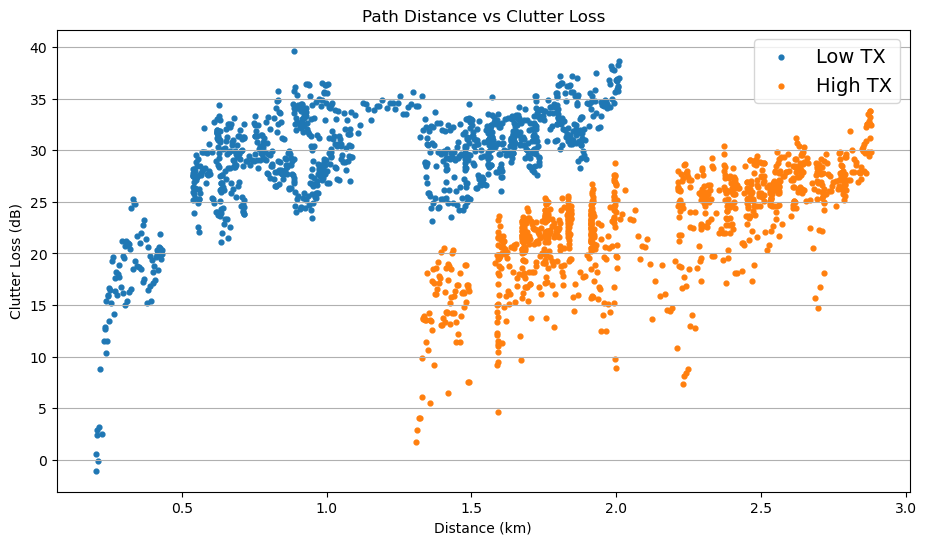

In [51]:
fig, ax = plt.subplots(figsize=(11, 6))
ax.scatter(low_df["d__km"], low_df["L_excess__db"], label='Low TX', s=12)
ax.scatter(high_df["d__km"], high_df["L_excess__db"], label='High TX', s=12)

ax.set_xlabel('Distance (km)')
ax.set_ylabel('Clutter Loss (dB)')
ax.set_title('Path Distance vs Clutter Loss')

ax.legend(fontsize=14)
ax.grid(True, axis="y")
plt.show()

The clutter loss versus path distance plot above shows there is no obvious global correlation between the two. Instead there seems to be a relationship depending on the transmitter height.

Because of the relationship between transmitter height (high vs low) and the clutter loss, let's calculate the _Rx elevation angle_ for all of the measurements in both datasets. 

<img src="./images/rx_elev_angle.png" alt="RX elevation angle" width="600"/>

### Add an "_Rx elevation angle_" column to high and low DataFrames

In [55]:
## use lidar to add antenna altitude to the dataframes for TX and RX antenna
def antenna_altitude(x: float, y: float, antenna_height: float, lidar_elev_band: np.ndarray):
    """Calculate the antenna altitude using lidar data
    
    :param x: Antenna location, column in lidar_elev_band
    :param y: Antenna location, row in lidar_elev_band
    :param antenna_height: Antenna height above ground level (meters)
    :param lidar_elev_band: Lidar data array, loaded with rasterio.io.DatasetReader.read()
    """
    elev = lidar_elev_band[int(y)][int(x)]
    return elev + antenna_height

for df in [low_df, high_df]:
    df["alt_rx__meter"] = df.apply(lambda row: antenna_altitude(row.RxX__meter, row.RxY__meter, row.h_rx__meter, band1_terrain), axis=1)
    df["alt_tx__meter"] = df.apply(lambda row: antenna_altitude(row.TxX__meter, row.TxY__meter, row.h_tx__meter, band1_terrain), axis=1)

def rx_elev_angle(alt_rx, alt_tx, d):
    """Get the RX elevation angle (in degrees)
    
    :param alt_rx: Altitude of RX (meters)
    :param alt_tx: Altitude of TX (meters)
    :param d: Ray distance between TX and TX (km)
    """
    soh = np.abs(alt_tx - alt_rx) / (d*1000)
    angle_deg = np.arcsin(soh)*360/(np.pi*2) 
    return angle_deg

## calculate the rx antenna angle and add a new column to the dataframe
# here we will use d_3d__km for the distance in the High-TX case, but use d__km as the distance in the low-TX case
high_df["rx_angle__deg"] = high_df.apply(lambda row: rx_elev_angle(row.alt_rx__meter, row.alt_tx__meter, row.d_3d__km), axis=1)
low_df["rx_angle__deg"] = low_df.apply(lambda row: rx_elev_angle(row.alt_rx__meter, row.alt_tx__meter, row.d__km), axis=1)

### Summary Statistics for RX Elevation Angle

In [56]:
print("\t\t\t\t\tMin\tMax\tMean\tSt Dev")

print("Low - RX elevation angle (deg)\t\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}".format(np.min(low_df["rx_angle__deg"]),
                                                                                     np.max(low_df["rx_angle__deg"]),
                                                                                     np.mean(low_df["rx_angle__deg"]),
                                                                                     np.std(low_df["rx_angle__deg"])))

print("High - RX elevation angle (deg)\t\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}".format(np.min(high_df["rx_angle__deg"]),
                                                                                     np.max(high_df["rx_angle__deg"]),
                                                                                     np.mean(high_df["rx_angle__deg"]),
                                                                                     np.std(high_df["rx_angle__deg"])))

					Min	Max	Mean	St Dev
Low - RX elevation angle (deg)		0.19	3.15	1.06	0.72
High - RX elevation angle (deg)		2.99	6.43	4.32	0.96


The Low TX dataset has an average Rx elevation angle of 1 degree. The High TX dataset has an average RX elevation angle of 4 degrees. This difference of 3 degrees seems correlated with an additional 10 dB of clutter loss in the Low TX caase, shown in the CDF plotted earlier.

### Plot Rx elevation angle vs clutter loss

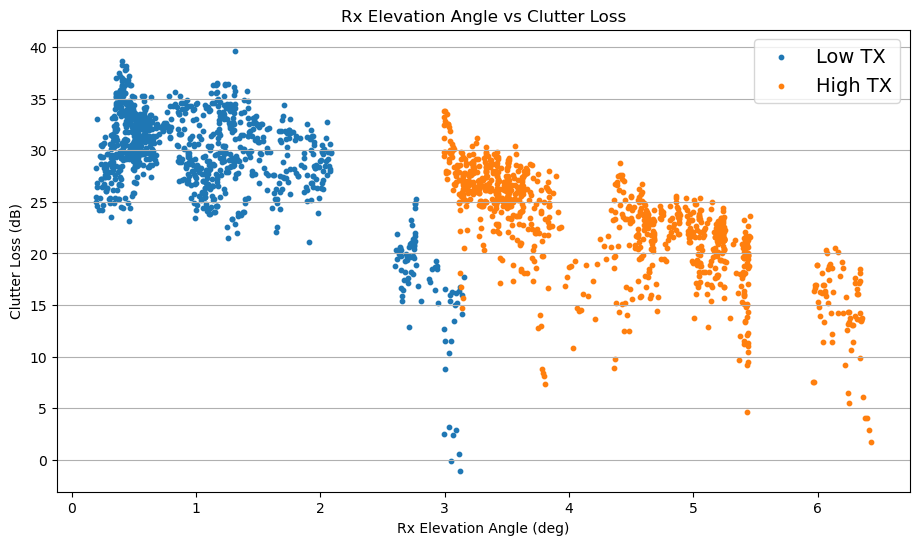

In [57]:
plt.scatter(low_df["rx_angle__deg"], low_df["L_excess__db"], label='Low TX', s=10)
plt.scatter(high_df["rx_angle__deg"], high_df["L_excess__db"], label='High TX', s=10)

plt.xlabel('Rx Elevation Angle (deg)')
plt.ylabel('Clutter Loss (dB)')
plt.title('Rx Elevation Angle vs Clutter Loss')

plt.legend(fontsize=14)
plt.gca().yaxis.grid(True)
plt.show()

Despite a few obvious outliers, there seems to be some relationship between Rx elevation angle and clutter loss. We leave it up to you to investigate possible explanations for the outliers. Let's continue investigating the Rx elevation angle and clutter loss trend by calculating 3D clutter distance.

### Develop the 3D Clutter Distance Model $r_c$

In this model we assume that clutter is an end-point phenomenon, only at the RX. We also assume that west of Martin Acres, the clutter ends and that propagation is through free space (with the road Broadway acting as the western boundary to the clutter region). Therefore, the clutter will be modeled as a __slab__ resting atop the terrain in the Martin Acres neighborhood. The slab height $h_c$ will be determined based on the clutter statistics gathered in lesson 2. The assumptions and construction of this modeling approach are shown below:

<img src="./images/clutter_slab.png" alt="Clutter Slab" width="800"/>

The Martin Acres clutter slab ends at Broadway, defined as the line that passes through the following two points. You'll plot this line in the next code cell. 
 * bway_north = (39.99741,-105.26273)
 * bway_south = (39.98587,-105.25248)

The slab height $h_c$ is based on the statistics we gathered in lesson 2. The mean clutter height $\mu_c$ is 8 meters and the standard deviation $\sigma_c$ is 4.5 meters. Let's define $h_c$ as: $$h_c = \mu_c + 2\sigma_c$$ $$h_c = \text{17 meters}$$ 
We chose this definition of $h_c$ after regression analysis showed that it approximately minimizes the prediction error of the model you're about to create for the Martin Acres dataset. We encourage you to play with different values of $h_c$ to see how it affects the model and the accuracy of the predictions. We further encourage you to think about the generalizability of such a construction to other propagation environments, which may or may not be similar to Martin Acres in a variety of ways.

### Calculate 3D Clutter Distance

We define the 3D Clutter Distance as the distance traversed by the direct ray from the TX _through the clutter slab_ to the RX within the clutter environment. There are two scenarios you must consider when finding the 3D Clutter Distance: 

**1.** Find the distance within the clutter if the path exits out of the top of the clutter slab. Defined as $h_c / \sin(\theta_\text{rx})$ where $\theta_\text{rx}$ is the RX elevation angle.

<img src="./images/3d_dist_top.png" alt="RX elevation angle" width="800"/>

**2.** Find the distance within the clutter if the path exits out of the side of the clutter slab, defined as $d_c$. This can be found by performing the intersection of the ray path with Broadway. 

<img src="./images/3d_dist_side.png" alt="RX elevation angle" width="800"/>

Ultimately, you will determine the 3D Clutter Distance, $r_c$, by finding the distance within the clutter for both scenarios. Then finding the minimum of both scenarios is an easy way to determine which scenario applies.

$$r_c = \text{MIN} (d_c , \frac{h_c}{\sin\theta_\text{rx}})$$


### Start by plotting the Broadway boundary of the slab

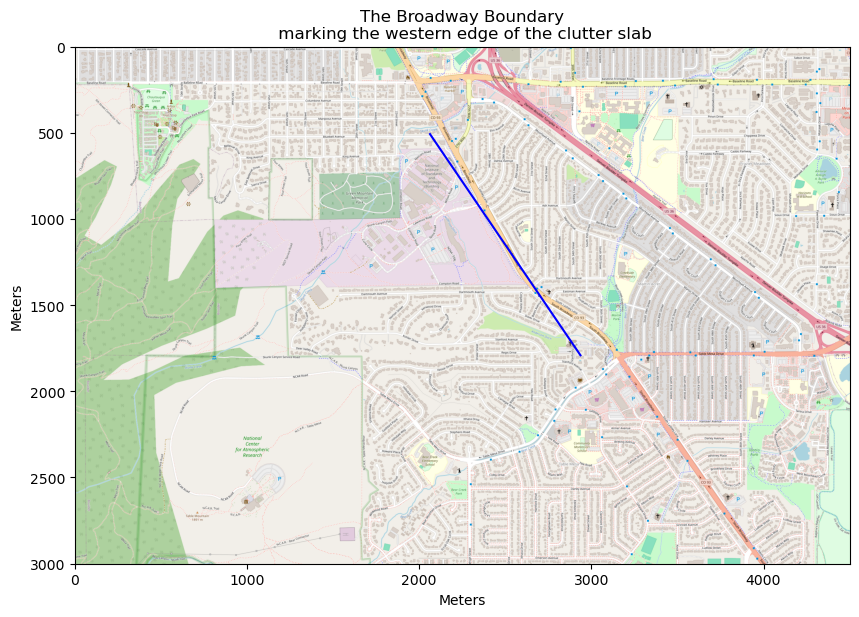

In [69]:
def convert_gps_to_meters(lat, long):
    lat_dif = top_deg - lat
    long_dif = long - left_deg
    vert_dif_m = lat_dif * meters_per_lat
    horz_dif_m = long_dif * meters_per_long
    return (vert_dif_m, horz_dif_m)

bway_n = convert_gps_to_meters(39.99741,-105.26273)
bway_s = convert_gps_to_meters(39.98587,-105.25248)

## make the plot
fig, ax = plt.subplots(figsize=(10, 10))
ex3 = ax.plot([bway_n[1],bway_s[1]], [bway_n[0],bway_s[0]], zorder=3, alpha=1.0, c='b')
ax.set_title('The Broadway Boundary\n marking the western edge of the clutter slab')
ax.set_xlabel("Meters")
ax.set_ylabel("Meters")
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(martin_acres_map, zorder=0, extent = BBox, aspect= 'equal')
plt.show()

### Find the distance from the RX location to the Broadway boundary

Add this distance as a new column (called `horizontal_d__meter`) to the DataFrame.

In [66]:
def m_intersect(tx_m, rx_m, line_s_m, line_e_m):
    """
    Find the intersection of the ray path with Broadway
    and return the distance of the intersection to the RX point

    :param tx_m: Tuple (Y, X) containing the TX point (meters)
    :param rx_m: Tuple (Y, X) containing the RX point (meters)
    :param line_s_m: Tuple (Y, X) containing Broadway line start coordinates (meters)
    :param line_e_m: Tuple (Y, X) containing Broadway line end coordinates (meters)
    """
    rise1 = tx_m[0] - rx_m[0]
    run1 = tx_m[1] - rx_m[1]
    m1 = rise1 / run1 ## find the slope of the first line
    
    rise2 = line_s_m[0] - line_e_m[0]
    run2 = line_s_m[1] - line_e_m[1]
    m2 = rise2 / run2 ## find the slope of the second line
    
    ## x and y are the intersection point (in meters)
    ## x = (m1*b - a - m2*d + c) / (m1 - m2)
    x = (m1*tx_m[1] - tx_m[0] - m2*line_s_m[1] + line_s_m[0]) / (m1 - m2)
    y = m1*(x-tx_m[1]) + tx_m[0]
    dist_from_rx = np.sqrt(np.square(x - rx_m[1]) + np.square(y - rx_m[0]))
    return dist_from_rx

## add new column to DataFrames, the distance from RX to Broadway
low_df["horizontal_d__meter"] = low_df.apply(lambda row: m_intersect((row.TxY__meter, row.TxX__meter), (row.RxY__meter, row.RxX__meter), bway_s, bway_n), axis=1)
high_df["horizontal_d__meter"] = high_df.apply(lambda row: m_intersect((row.TxY__meter, row.TxX__meter), (row.RxY__meter, row.RxX__meter), bway_s, bway_n), axis=1)

### Plot the distance from RX to Broadway

This step serves as a bit of a sanity check before we continue. Can we visually see that we are correctly defining the distance from Rx points to Broadway, for both datasets? Does our simple line approximate the actual physical boundary of Broadway well? Viewing these plots shows that the "distance to Broadway" values seem to make sense across the datasets.

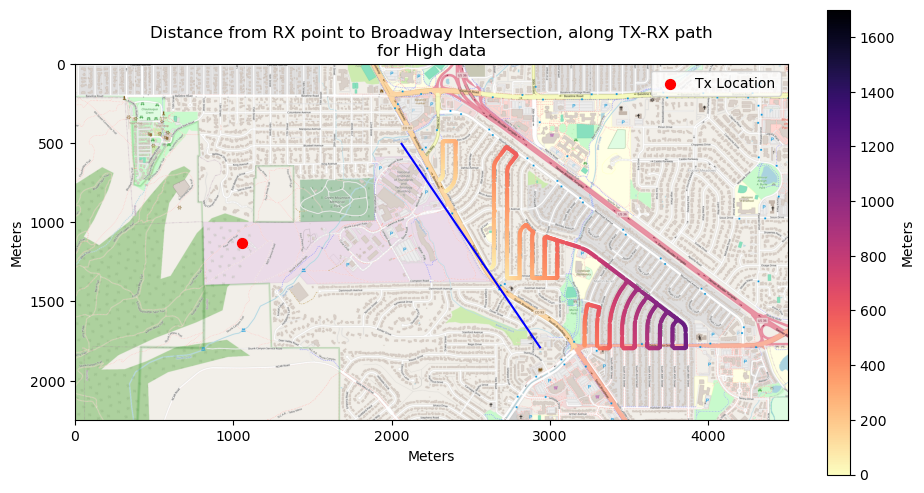

In [76]:
## make the plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(high_df.iloc[0]["TxX__meter"],high_df.iloc[0]["TxY__meter"], zorder=2, alpha=1.0, c='r', s=50, label="Tx Location")
ax.plot([bway_n[1],bway_s[1]], [bway_n[0],bway_s[0]], zorder=3, alpha=1.0, c='b')
ex1 = ax.scatter(high_df["RxX__meter"], high_df["RxY__meter"], zorder=1, c=high_df["horizontal_d__meter"], cmap='magma_r', alpha= 1.0, s=4, vmin=0, vmax=1700)
cbar = plt.colorbar(ex1, fraction=0.03, label="Meters")

ax.set_title('Distance from RX point to Broadway Intersection, along TX-RX path\nfor High data')
ax.set_xlabel("Meters")
ax.set_ylabel("Meters")
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2]-(BBox[2]/4),BBox[3])
ax.imshow(martin_acres_map, zorder=0, extent = BBox, aspect= 'equal')
ax.legend()
plt.show()

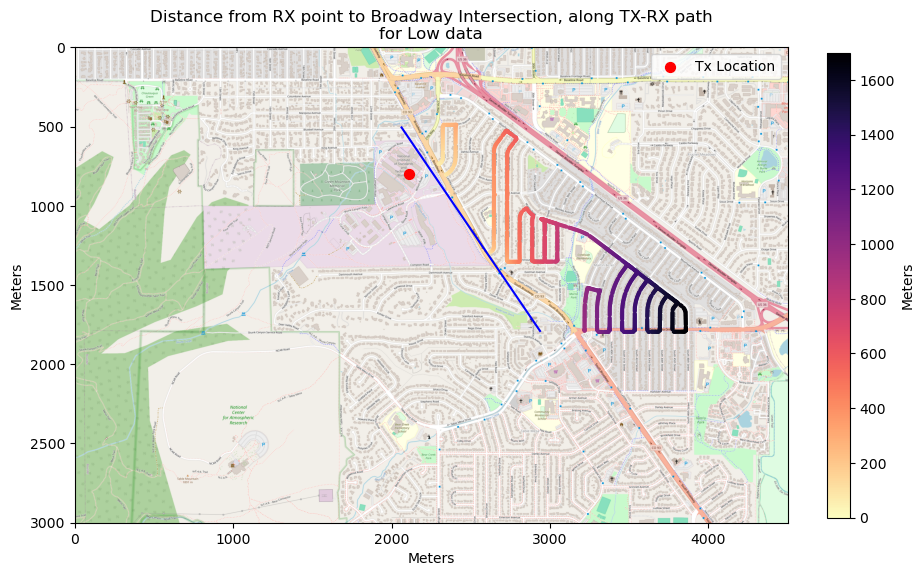

In [77]:
## make the plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(low_df.iloc[0]["TxX__meter"],low_df.iloc[0]["TxY__meter"], zorder=2, alpha=1.0, c='r', s=50, label="Tx Location")
ax.plot([bway_n[1],bway_s[1]], [bway_n[0],bway_s[0]], zorder=3, alpha=1.0, c='b')
ex1 = ax.scatter(low_df["RxX__meter"], low_df["RxY__meter"], zorder=1, c=low_df["horizontal_d__meter"], cmap='magma_r', alpha= 1.0, s=4, vmin=0, vmax=1700)
cbar = plt.colorbar(ex1, fraction=0.03, label="Meters")

plt.title('Distance from RX point to Broadway Intersection, along TX-RX path\nfor Low data')
plt.xlabel("Meters")
plt.ylabel("Meters")
plt.xlim(BBox[0],BBox[1])
plt.ylim(BBox[2],BBox[3])
plt.imshow(martin_acres_map, zorder=0, extent = BBox, aspect= 'equal')
plt.legend()
plt.show()

### Find the 3D Clutter Distance $r_c$

$r_c = \text{MIN} (d_c , \frac{h_c}{\sin\theta_\text{rx}})$ and add it as a new column called `clutter_d__meter`.

In [79]:
h_c = clutter_height_mean + 2*clutter_height_std  # From our earlier definition

def clutter_distance(horizontal_d, rep_clutter_height, rx_angle):
    return min(horizontal_d, rep_clutter_height/np.sin(np.radians(rx_angle)))

## add the new clutter distance columns
low_df["clutter_d__meter"] = low_df.apply(lambda row: clutter_distance(row.horizontal_d__meter, h_c, row.rx_angle__deg), axis=1)
high_df["clutter_d__meter"] = high_df.apply(lambda row: clutter_distance(row.horizontal_d__meter, h_c, row.rx_angle__deg), axis=1)

### plot the 3D Clutter Distance vs Clutter Loss

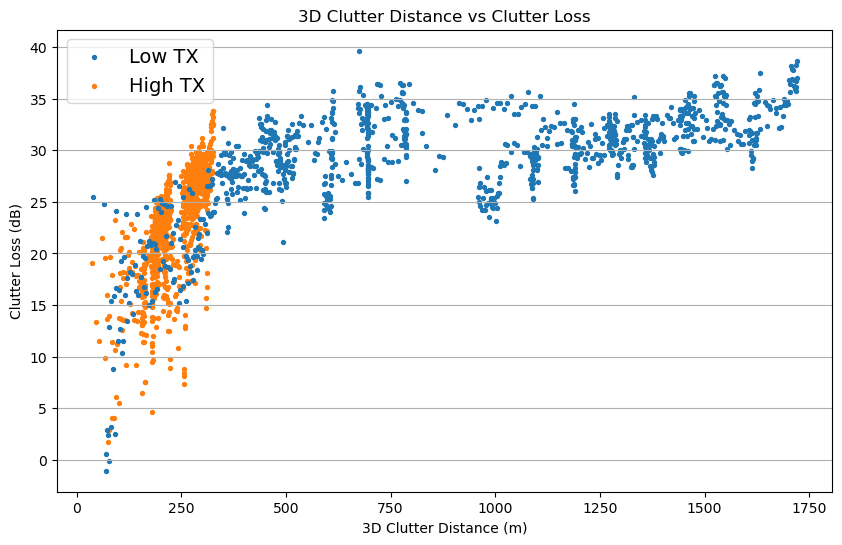

In [81]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(low_df["clutter_d__meter"], low_df["L_excess__db"], label='Low TX', s=8, zorder=1)
ax.scatter(high_df["clutter_d__meter"], high_df["L_excess__db"], label='High TX', s=8, zorder=0)

ax.set_xlabel('3D Clutter Distance (m)')
ax.set_ylabel('Clutter Loss (dB)')
ax.set_title('3D Clutter Distance vs Clutter Loss')
  
ax.legend(fontsize=14)
ax.grid(True, axis="y")
plt.show()

Pause and take a look at the relationship between 3D clutter distance and clutter loss. Unlike the "Path Distance vs Clutter Loss" figure, there is a clear relationship between 3D clutter distance and clutter loss. The 3D clutter distance has had a major effect on the High Tx data. High Tx data is now pushed toward the left of the plot because its signal paths exit the Martin Acres clutter sooner than the Low Tx signal paths. There is now a clear logarithmic relationship between 3D clutter distance and clutter loss. Additionally, the data are no longer completely distinct based on TX location; many Low TX and High TX points overlap in this figure.

### Plot the logarithmic transform of the data

Apply a log transform to the x axis (3D clutter distance). There should be a linear relationship between log(3D clutter distance) and clutter loss.

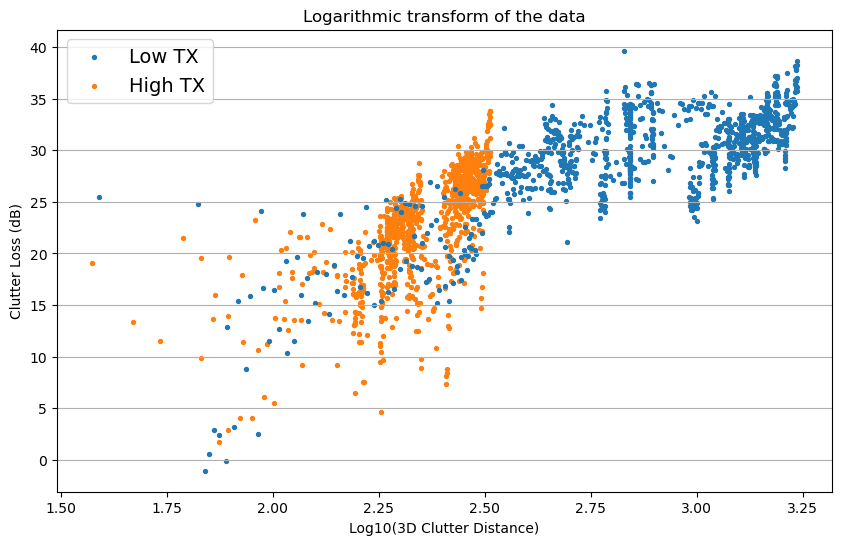

In [82]:
fig, ax = plt.subplots(figsize=(10, 6))
## the x data now has a np.log10() function applied to it
ax.scatter(np.log10(low_df["clutter_d__meter"]), low_df["L_excess__db"], label='Low TX', s=8, zorder=1)
ax.scatter(np.log10(high_df["clutter_d__meter"]), high_df["L_excess__db"], label='High TX', s=8, zorder=0)

ax.set_xlabel('Log10(3D Clutter Distance)')
ax.set_ylabel('Clutter Loss (dB)')
ax.set_title('Logarithmic transform of the data')
  
ax.legend(fontsize=14)
ax.grid(True, axis="y")
plt.show()

### Fit log-transformed data with a linear regression model

The regression model will fit a line to the data that minimizes squared errors. The line represents the median clutter loss observed at a given 3D clutter distance. Let $L_{c,m}$ be the median clutter loss. Then $L_{c,m} = a \text{log}_{10}r_c+b$, where $r_c$ is the 3D clutter distance. The linear regression will find the best $a$ and $b$ to fit the data.

In [83]:
## concatinate the high and low dataframes
df1 = high_df[["clutter_d__meter", "L_excess__db"]]
df2 = low_df[["clutter_d__meter", "L_excess__db"]]
full_df = pd.concat([df1, df2])

## perform the linear regression on the data
linear_regression = LinearRegression()
linear_regression.fit(np.array(np.log10(full_df["clutter_d__meter"])).reshape(-1,1), full_df["L_excess__db"])
y_int = linear_regression.intercept_
slope = linear_regression.coef_[0]
print("a = {:.2f} \nb = {:.2f}".format(slope, y_int))
print("L_cm = {:.2f} * log10(r_c) + {:.2f}".format(slope, y_int))

a = 13.71 
b = -9.80
L_cm = 13.71 * log10(r_c) + -9.80


### Plot with the fit line with the measurement data

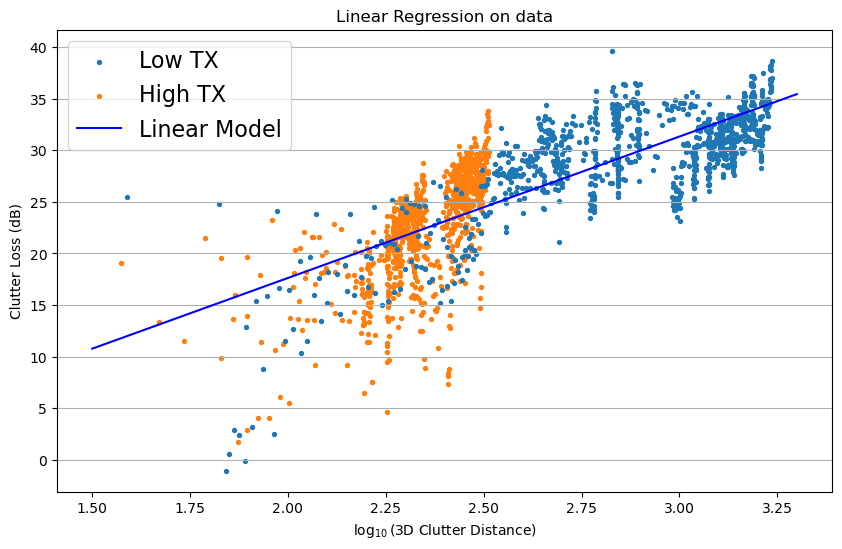

In [87]:
fig, ax = plt.subplots()
ax.scatter(np.log10(low_df["clutter_d__meter"]), low_df["L_excess__db"], label='Low TX', s=8, zorder=1)
ax.scatter(np.log10(high_df["clutter_d__meter"]), high_df["L_excess__db"], label='High TX', s=8, zorder=0)

## add the regression line
z_point = (1.5, slope*1.5 + y_int)
n_point = (3.3, slope*3.3 + y_int)

ax.plot([z_point[0], n_point[0]],[z_point[1], n_point[1]], c='b', label="Linear Model")
ax.set_xlabel(r'$\log_{10}$(3D Clutter Distance)')
ax.set_ylabel('Clutter Loss (dB)')
ax.set_title('Linear Regression on data')
  
ax.legend(fontsize=16)
ax.grid(True, axis="y")
plt.show()

### Transform back to linear units

Now that we've done our linear fit in the log-domain, let's see how things look when put back on a linear scale.

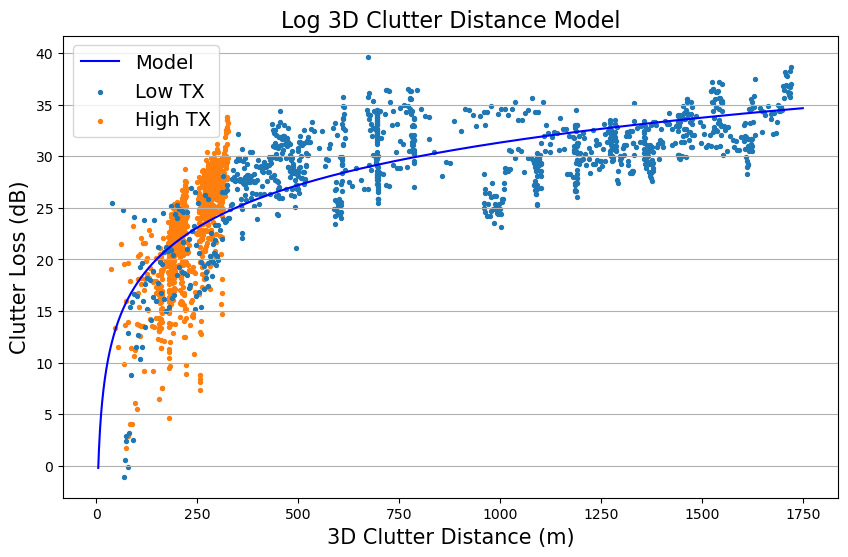

In [88]:
full_x = np.linspace(5,1750,2000)
full_y = slope*np.log10(full_x) + y_int

fig, ax = plt.subplots()
ax.plot(full_x, full_y, label='Model', c='b')

ax.scatter(low_df["clutter_d__meter"], low_df["L_excess__db"], label='Low TX', s=8, zorder=1)
ax.scatter(high_df["clutter_d__meter"], high_df["L_excess__db"], label='High TX', s=8, zorder=0)

ax.set_xlabel('3D Clutter Distance (m)', fontsize=15)
ax.set_ylabel('Clutter Loss (dB)', fontsize=15)
ax.set_title('Log 3D Clutter Distance Model', fontsize=16)
ax.legend(fontsize=14)
ax.grid(True, axis="y")
plt.show()

### Your median clutter loss model is...

In [98]:
print(f"L_cm = {slope:.2f} * log10(r_c) + {y_int:.2f}")

L_cm = 13.71 * log10(r_c) + -9.80


### Plot the residuals of the regression model 

One useful metric for analyzing the prediction accuracy of a model is the residual. The clutter model's residual is defined here as the measured basic transmission loss in excess of free space minus the predicted clutter loss. A good model will have small residuals which are symmetrically distributed about zero- in this case, we can say that the model is an accurate predictor for the measurement, and that the model is equally likely to over- or under-predict clutter loss.

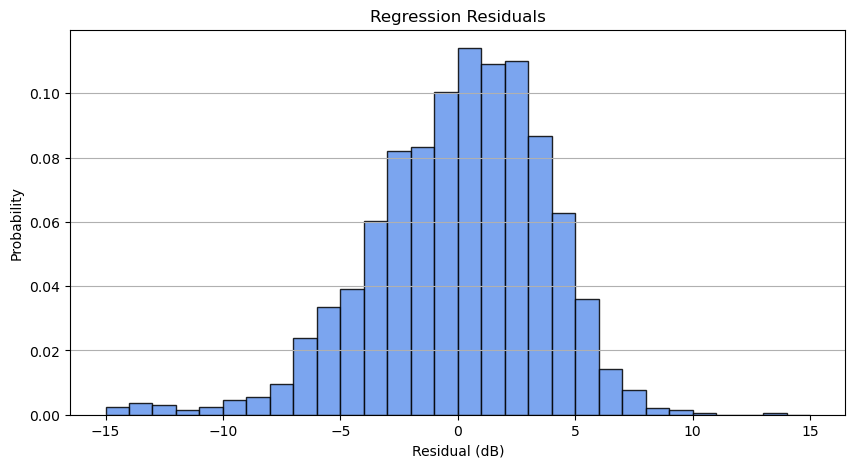

In [99]:
## define the clutter model
def model(r_c):
    return slope * np.log10(r_c) + y_int

## add column for predicted loss based on the clutter model
full_df["pred_loss"] = full_df["clutter_d__meter"].map(model)

## add a column for the prediction error
full_df["error"] = full_df.apply(lambda row: row.L_excess__db - row.pred_loss, axis=1)

## plot the histogram of the residuals
fig, ax = plt.subplots(figsize=(10, 5))
n, bins, patches = ax.hist(full_df["error"], np.linspace(-15,15,31), density=True, facecolor='cornflowerblue', alpha=.85, edgecolor='black')
ax.set_xlabel('Residual (dB)')
ax.set_ylabel('Probability')
ax.set_title('Regression Residuals')
ax.grid(True, axis="y")
plt.show()

### Plot model with 10%, 50%, and 90% variability bounds

Our model predicts the median clutter loss. Let's expand our results to find predicted clutter loss curves which should bound 90% or 10% of the measured data. Then, let's plot all of the measured data along with the 10%, 50% (median), and 90% prediction curves.

In [100]:
## sort errors and find 10% and 90% bounds
full_N = len(full_df)
full_sorted_x = np.sort(full_df["error"])
full_sorted_y = np.arange(full_N) / float(full_N)
idx_10 = np.where(full_sorted_y > 0.1)[0][0]
idx_90 = np.where(full_sorted_y > 0.9)[0][0]

print("10% is at + {:.1f} dB".format(full_sorted_x[idx_10]))
print("90% is at + {:.1f} dB".format(full_sorted_x[idx_90]))

10% is at + -4.7 dB
90% is at + 4.4 dB


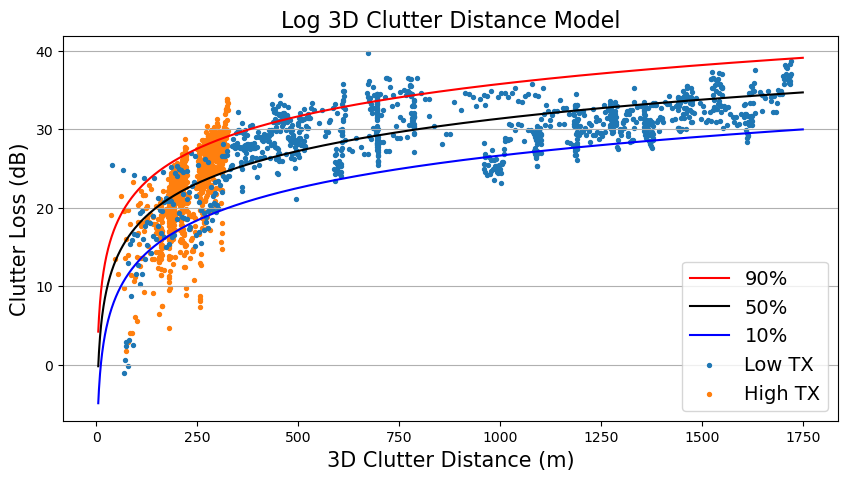

In [104]:
full_x = np.linspace(5,1750,2000)
full_y = slope*np.log10(full_x) + y_int

## create plot
fig, ax = plt.subplots()

## plot 90%
ax.plot(full_x, full_y + full_sorted_x[idx_90], label='90%', c='r')
## plot median
ax.plot(full_x, full_y, label='50%', c='black')
## plot 10%
ax.plot(full_x, full_y + full_sorted_x[idx_10], label='10%', c='b')
## plot measured data
ax.scatter(low_df["clutter_d__meter"], low_df["L_excess__db"], label='Low TX', s=8, zorder=1)
ax.scatter(high_df["clutter_d__meter"], high_df["L_excess__db"], label='High TX', s=8, zorder=0)

ax.set_xlabel('3D Clutter Distance (m)', fontsize=15)
ax.set_ylabel('Clutter Loss (dB)', fontsize=15)
ax.set_title('Log 3D Clutter Distance Model', fontsize=16)
ax.legend(fontsize=14)
ax.grid(True, axis="y")
plt.show()

The 10%, 50%, and 90% curves capture the location varibility present within the measurements. The location variability causes a +/- 4.5 dB spread around the median. These values are included in the statistical propagation model that you just found.

$$\Huge L_c = 13.7*\text{log}_{10}(r_c) - 9.8 \pm 4.5 \text{dB}$$

Well done, you've created a statistical clutter model based on propagation measurements and lidar. In the next less you'll compare your model to a well known clutter model from Recommendation ITU-R P.2108. 

End of Lesson 3